# Pendulum upswing using Q-learning
This notebook shows an example of the q learning algorithem being used to swing a pendulum up to a vertical position when it has tourque limitations

In [1]:
# Set relative path to parent directory
import sys, os
sys.path.insert(0, os.path.abspath('..'))

## Pendulum environment
We first import the pendulum environment and define the discreteization of the actions and states, as well as defining the reward function. 

In [2]:
from environments.pendulum import pendulum
import numpy as np
env = pendulum()
env.step_size = 0.1

r = lambda theta : ((theta/np.pi - 1) % 2)*np.pi - np.pi
env.actions = lambda: [0, -4, 4]
env.reward = lambda:  np.max([10 - (100*np.abs(env.x[0])), 0])
env.state = lambda: [int(np.round(r(env.x[0])*100)), int(np.round(env.x[1]*10))]

## Q-learning algorithm

In [3]:
import numpy as np

q_default = 0

def Q_Learning(env, gamma, alpha, epsilon, Q = dict()):
    # Initialize environment
    theta = (2*np.random.rand()-1)*0.01
    s = env.init([theta, 0])
    
    while(np.abs(s[0]) < 700 and np.abs(s[1]) < 70):
        # Select action (epsilon greedy)
        if np.random.rand() < epsilon:
            a = env.actions()[np.argmax([Q.get((*s, action), q_default) for action in env.actions()])]
        else:
            a = np.random.choice(env.actions())
        
        # Perform action and observe reward
        env.step(a)
        r = env.reward()
        s_next = env.state()
        
        # Q update
        lst = [Q.get((*s_next, action), q_default) for action in env.actions()]
        Q[(*s, a)] = Q.get((*s, a), q_default) + alpha*(r + gamma*np.max(lst) - Q.get((*s, a), q_default))
        
        s = s_next
    return Q

### Start training

In [4]:
import numpy as np

Q = dict()
NUM_EPISODES = 10
for e in range(NUM_EPISODES):
    epsilon = 0.95*e/NUM_EPISODES #Decaying random coice of action
    #epsilon = 0.99
    Q = Q_Learning(env , gamma = 0.9 , alpha = 0.5, epsilon = epsilon, Q = Q)
    print("Episode: {}, Epsilon: {:1.4f}, Q size: {}".format(e, epsilon, len(Q)))

Episode: 0, Epsilon: 0.0000, Q size: 28
Episode: 1, Epsilon: 0.0950, Q size: 54
Episode: 2, Epsilon: 0.1900, Q size: 98
Episode: 3, Epsilon: 0.2850, Q size: 124
Episode: 4, Epsilon: 0.3800, Q size: 168
Episode: 5, Epsilon: 0.4750, Q size: 281
Episode: 6, Epsilon: 0.5700, Q size: 312
Episode: 7, Epsilon: 0.6650, Q size: 350
Episode: 8, Epsilon: 0.7600, Q size: 427
Episode: 9, Epsilon: 0.8550, Q size: 451


### Save and load Q values

In [5]:
import pickle

#pickle.dump( Q, open( "q_vals.p", "wb" ) )
Q = pickle.load(open( "q_vals.p", "rb" ))

## Run model with Q the given q values

In [6]:
from matplotlib import pyplot as plt
import numpy as np
%matplotlib auto

env.render()


env.init([np.pi, 0])
sampels = 100
y = np.zeros((sampels, 2))
q = np.zeros((sampels, 1))
y[0, :] = env.x


for t in range(sampels):
    s = env.state()
    u = env.actions()[np.argmax([Q.get((*s, action), -100) for action in env.actions()])]
    env.step(u)
    y[t, :] = env.state()
    q[t] = Q.get((*s, u), -1)
    plt.pause(0.01)
    #if t%10 == 0:
    #    env.render()
    
t = np.linspace(0, env.step_size*(sampels-1), sampels)

Using matplotlib backend: Qt5Agg


C:\Users\andreabm\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\site-packages\matplotlib\backend_bases.py:2453: MatplotlibDeprecationWarning: Using default event loop until function specific to this GUI is implemented
  warnings.warn(str, mplDeprecation)


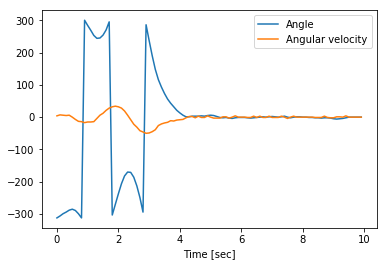

In [7]:
from matplotlib import pyplot as plt
%matplotlib inline
plt.plot(t,y)
#plt.plot(t, q*10)
plt.xlabel('Time [sec]')
plt.legend(['Angle','Angular velocity'])
plt.show()